# MSDS 7331 - Lab 3 - Airline Satisfaction Dataset
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

#### The dataset chosen is a compilation of airline customer satisfaction surveys.  The goal is to select from one of features (Association Rule Mining, Clustering, or Collaborative Filtering) to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed) to help us understand the customer sastification. 

Source: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download&select=test.csv

In [30]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

# Import Cluster Analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
import scipy.cluster.hierarchy as sch

#import visualization libraries
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

***
### Data Understanding (20 points total)
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [31]:
# load the airline satisfaction  dataset

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331/main/airline.csv') # read in the csv file
df.head()

#reduced samples set from 100,000 to 30,000 as a few of us had computer performance issues
df = df.sample(n=30000)

#### Check for NAs


In [32]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

print("Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.")

Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.


#### Remove unwanted columns
ID was removed from the dataset as it was used as a unique identified for each passenger

In [33]:
df["GenderNumeric"] = (df["Gender"]=="Male").astype(int)
df["CustomerTypeNumeric"] = (df["Customer Type"]=="Loyal Customer").astype(int)
df["TypeofTravelNumeric"] = (df["Type of Travel"]=="Personal Travel").astype(int)
df["ClassNumeric"] = df["Class"]
df["ClassNumeric"].replace(['Eco', 'Eco Plus', 'Business'], [0, 1, 2], inplace=True)

df["Arrival Delay in Minutes"]= df["Arrival Delay in Minutes"].fillna(0)


dfclean = df.drop(columns=['id'])

dfclean.isnull().sum() #double check on the missing values - 'arrival delay in minutes =310'

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
GenderNumeric                        0
CustomerTypeNumeric                  0
TypeofTravelNumeric      

In [34]:
#Fill in missing values
dfclean["Arrival Delay in Minutes"].fillna(dfclean["Arrival Delay in Minutes"].median(), inplace=True)

In [35]:
dfclean.describe().T

count         mean         std   min  \
Age                                30000.0    39.334933   15.191620   7.0   
Flight Distance                    30000.0  1185.294200  995.244692  56.0   
Inflight wifi service              30000.0     2.733800    1.325618   0.0   
Departure/Arrival time convenient  30000.0     3.070533    1.519792   0.0   
Ease of Online booking             30000.0     2.763467    1.402326   0.0   
Gate location                      30000.0     2.982833    1.274517   1.0   
Food and drink                     30000.0     3.205667    1.330975   0.0   
Online boarding                    30000.0     3.254833    1.347400   0.0   
Seat comfort                       30000.0     3.441867    1.317325   0.0   
Inflight entertainment             30000.0     3.354667    1.330966   0.0   
On-board service                   30000.0     3.378467    1.292163   0.0   
Leg room service                   30000.0     3.348433    1.313222   0.0   
Baggage handling                   30000.0     3.633100    1.183525   1.0   
Checkin service                    30000.0     3.306267    1.260868   0.0   
Inflight service                   30000.0     3.635100    1.174618   0.0   
Cleanliness                        30000.0     3.277667    1.310862   0.0   
Departure Delay in Minutes         30000.0    14.832100   38.715505   0.0   
Arrival Delay in Minutes           30000.0    15.139167   39.175024   0.0   
GenderNumeric                      30000.0     0.494767    0.499981   0.0   
CustomerTypeNumeric                30000.0     0.819733    0.384416   0.0   
TypeofTravelNumeric                30000.0     0.313500    0.463923   0.0   
ClassNumeric                       30000.0     1.025100    0.962515   0.0   

                                     25%    50%     75%     max  
Age                                 27.0   40.0    51.0    85.0  
Flight Distance                    409.0  838.0  1733.0  4983.0  
Inflight wifi service                2.0    3.0     4.0     5.0  
Departure/Arrival time convenient    2.0    3.0     4.0     5.0  
Ease of Online booking               2.0    3.0     4.0     5.0  
Gate location                        2.0    3.0     4.0     5.0  
Food and drink                       2.0    3.0     4.0     5.0  
Online boarding                      2.0    3.0     4.0     5.0  
Seat comfort                         2.0    4.0     5.0     5.0  
Inflight entertainment               2.0    4.0     4.0     5.0  
On-board service                     2.0    4.0     4.0     5.0  
Leg room service                     2.0    4.0     4.0     5.0  
Baggage handling                     3.0    4.0     5.0     5.0  
Checkin service                      3.0    3.0     4.0     5.0  
Inflight service                     3.0    4.0     5.0     5.0  
Cleanliness                          2.0    3.0     4.0     5.0  
Departure Delay in Minutes           0.0    0.0    12.0  1592.0  
Arrival Delay in Minutes             0.0    0.0    13.0  1584.0  
GenderNumeric                        0.0    0.0     1.0     1.0  
CustomerTypeNumeric                  1.0    1.0     1.0     1.0  
TypeofTravelNumeric                  0.0    0.0     1.0     1.0  
ClassNumeric                         0.0    1.0     2.0     2.0

In [36]:
dfclean.corr()

Age  Flight Distance  \
Age                                1.000000         0.095792   
Flight Distance                    0.095792         1.000000   
Inflight wifi service              0.014864         0.008176   
Departure/Arrival time convenient  0.035239        -0.022353   
Ease of Online booking             0.023151         0.063224   
Gate location                     -0.002422        -0.000708   
Food and drink                     0.021622         0.063015   
Online boarding                    0.196895         0.221073   
Seat comfort                       0.149230         0.157526   
Inflight entertainment             0.067606         0.130750   
On-board service                   0.056314         0.111646   
Leg room service                   0.039365         0.135097   
Baggage handling                  -0.054027         0.065095   
Checkin service                    0.037351         0.073353   
Inflight service                  -0.057037         0.057505   
Cleanliness                        0.041702         0.095258   
Departure Delay in Minutes        -0.001083        -0.004703   
Arrival Delay in Minutes          -0.002608        -0.008303   
GenderNumeric                      0.011782         0.008574   
CustomerTypeNumeric                0.274462         0.229053   
TypeofTravelNumeric               -0.054644        -0.269192   
ClassNumeric                       0.137319         0.452714   

                                   Inflight wifi service  \
Age                                             0.014864   
Flight Distance                                 0.008176   
Inflight wifi service                           1.000000   
Departure/Arrival time convenient               0.342108   
Ease of Online booking                          0.709512   
Gate location                                   0.334325   
Food and drink                                  0.132110   
Online boarding                                 0.456570   
Seat comfort                                    0.120905   
Inflight entertainment                          0.209194   
On-board service                                0.127203   
Leg room service                                0.163559   
Baggage handling                                0.121149   
Checkin service                                 0.040403   
Inflight service                                0.108130   
Cleanliness                                     0.133005   
Departure Delay in Minutes                     -0.021396   
Arrival Delay in Minutes                       -0.022669   
GenderNumeric                                   0.010371   
CustomerTypeNumeric                             0.006109   
TypeofTravelNumeric                            -0.114391   
ClassNumeric                                    0.042283   

                                   Departure/Arrival time convenient  \
Age                                                         0.035239   
Flight Distance                                            -0.022353   
Inflight wifi service                                       0.342108   
Departure/Arrival time convenient                           1.000000   
Ease of Online booking                                      0.434980   
Gate location                                               0.451905   
Food and drink                                              0.010296   
Online boarding                                             0.065436   
Seat comfort                                                0.011672   
Inflight entertainment                                     -0.004935   
On-board service                                            0.070667   
Leg room service                                            0.013541   
Baggage handling                                            0.076305   
Checkin service                                             0.089204   
Inflight service                                            0.070493   
Cleanliness                       

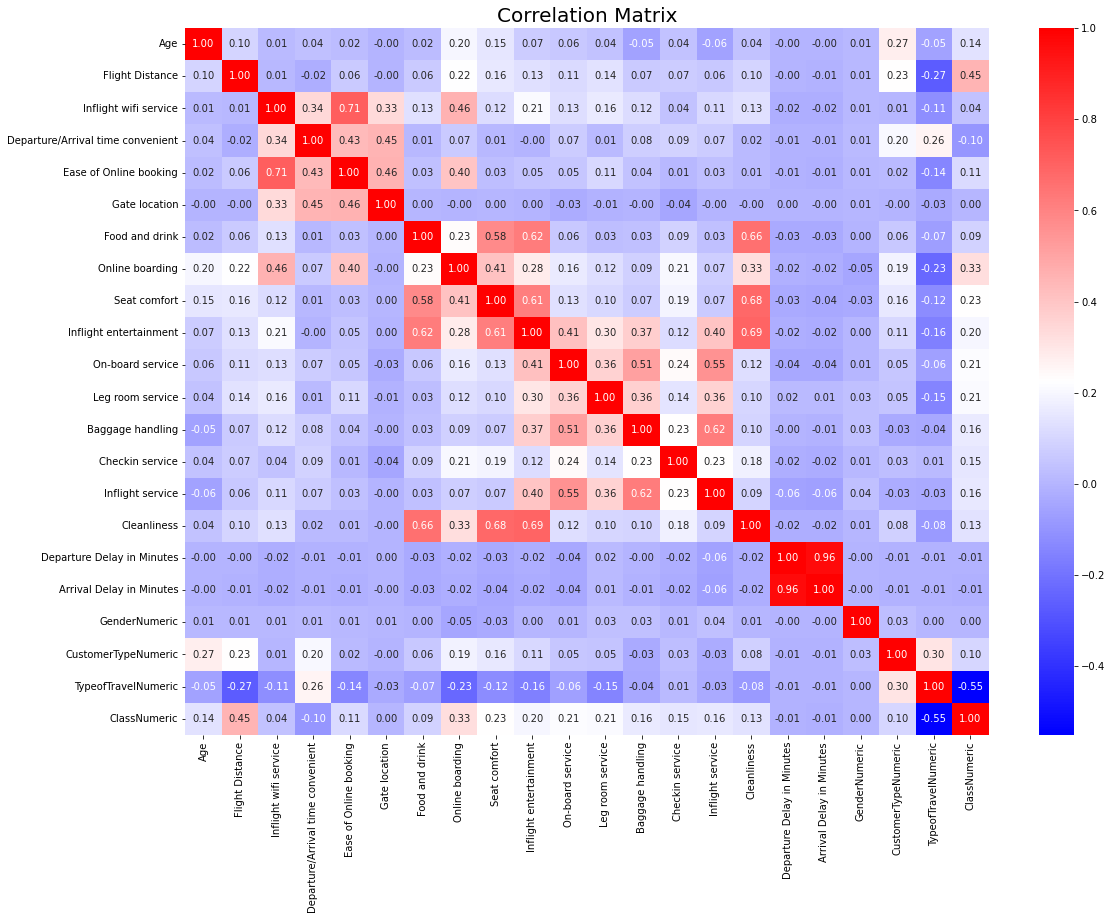

In [37]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(dfclean.corr(), annot=True, fmt=".2f", ax=ax, cmap="bwr")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

Very strong correlations (values from 0.8 to 1 or -0.8 to -1.0)
Strong correlations (values from 0.6 to 0.8 or -0.6 to -0.8)
Moderate correlations (values from 0.4 to 0.6 or -0.4 to -0.6) 

#### Check distribution of the data

C:\Users\thud1\anaconda3\envs\ML7331\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



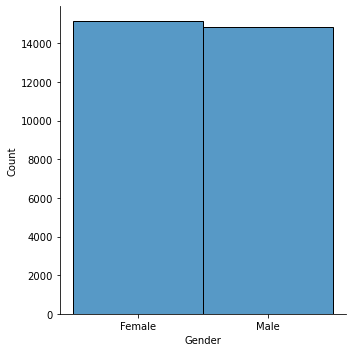

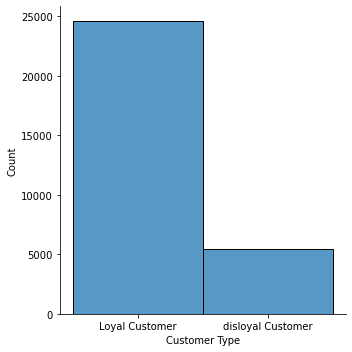

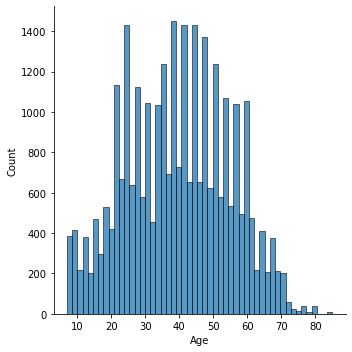

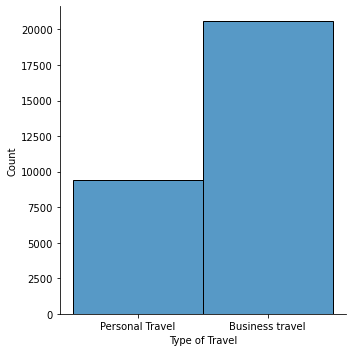

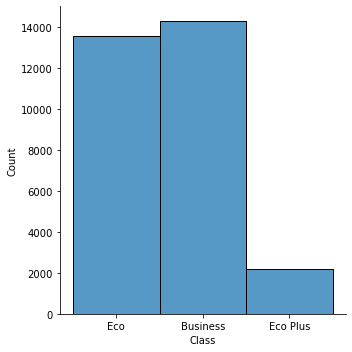

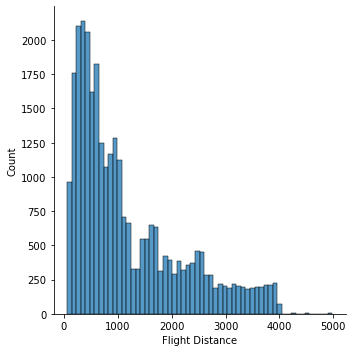

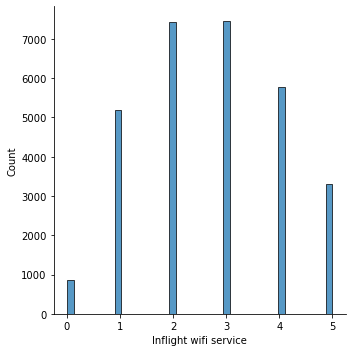

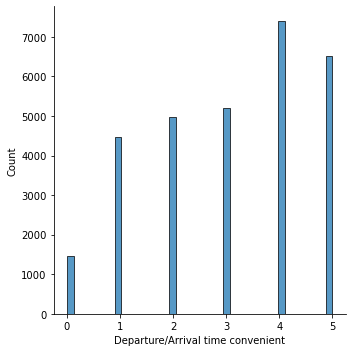

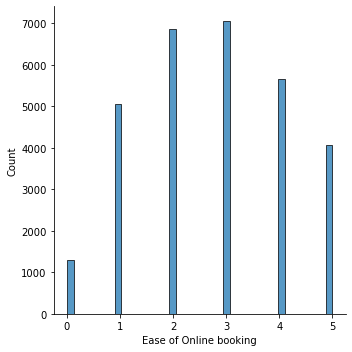

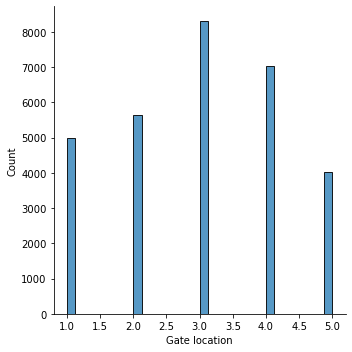

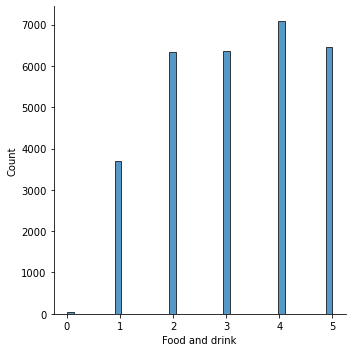

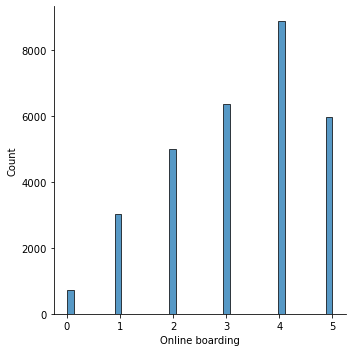

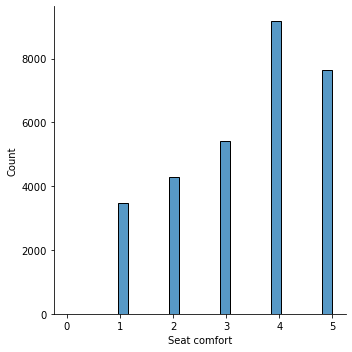

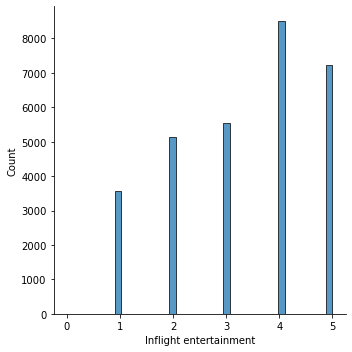

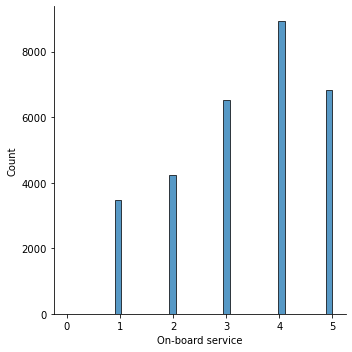

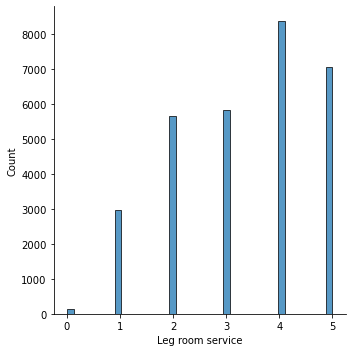

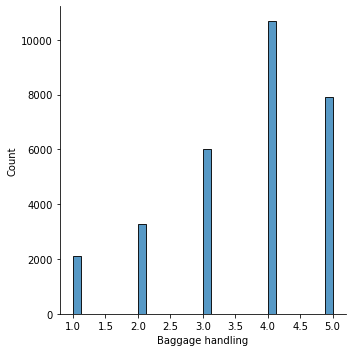

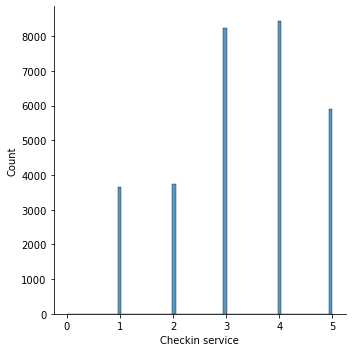

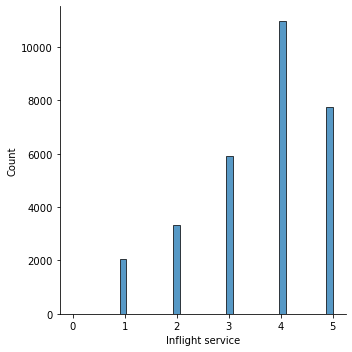

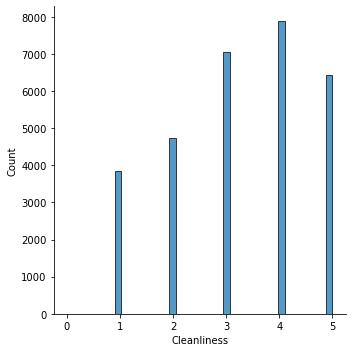

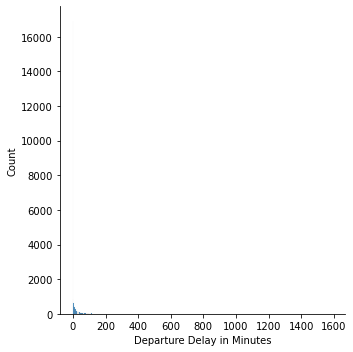

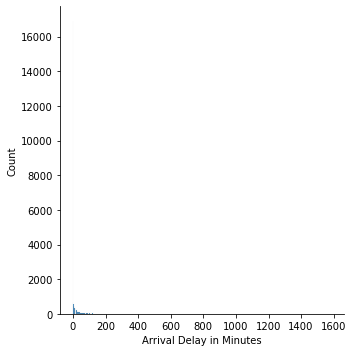

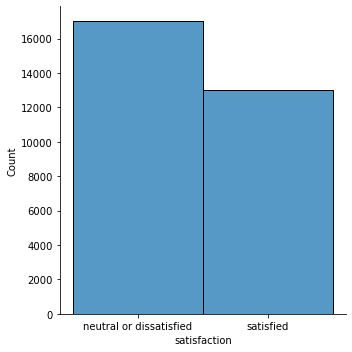

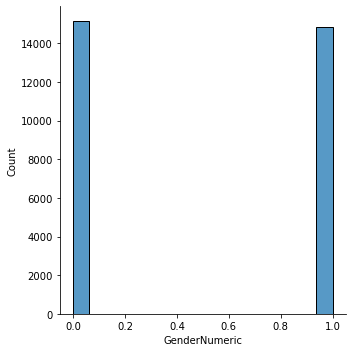

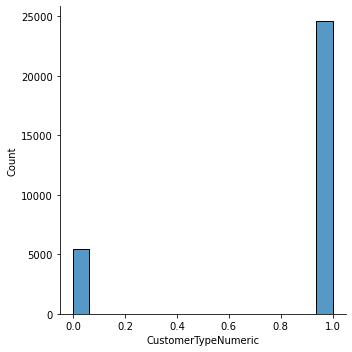

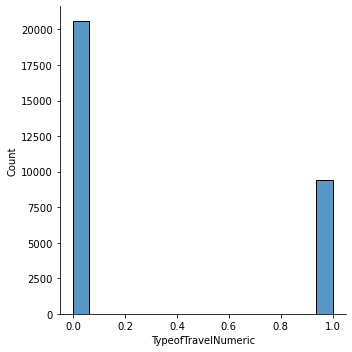

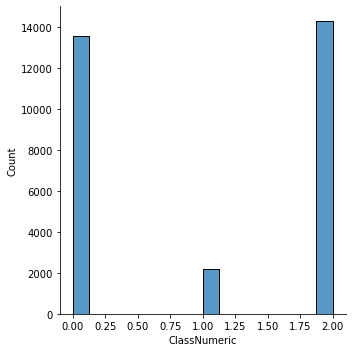

In [38]:
##distribution of the data

for column in dfclean:
    
    sns.displot(x=column, data=dfclean)

In [39]:
print (dfclean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 55211 to 5006
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             30000 non-null  object 
 1   Customer Type                      30000 non-null  object 
 2   Age                                30000 non-null  int64  
 3   Type of Travel                     30000 non-null  object 
 4   Class                              30000 non-null  object 
 5   Flight Distance                    30000 non-null  int64  
 6   Inflight wifi service              30000 non-null  int64  
 7   Departure/Arrival time convenient  30000 non-null  int64  
 8   Ease of Online booking             30000 non-null  int64  
 9   Gate location                      30000 non-null  int64  
 10  Food and drink                     30000 non-null  int64  
 11  Online boarding                    30000 non-null  

#### Summary of values to be used in classification modeling
A total of +100,000 passenger results are recorded in this data set.
We have a combination of categorical, ordinal and continous variable in this dataset.

- __Gender:__- Gender of the passengers (Female, Male) - Categorical Variable
- __Customer Type:__- The customer type (Loyal customer, disloyal customer) - Categorical Variable
- __Age:__- The actual age of the passengers - Continous Variable
- __Type of Travel:__- Purpose of the flight of the passengers (Personal Travel, Business Travel) - Categorical Variable
- __Class:__- Travel class in the plane of the passengers (Business, Eco, Eco Plus) - Categorical Variable
- __Flight distance:__- The flight distance of this journey - Continous Variable
- __Inflight wifi service:__- Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) - Categorical Variable
- __Departure/Arrival time convenient:__- Satisfaction level of Departure/Arrival time convenient - Categorical Variable
- __Ease of Online booking:__- Satisfaction level of online booking - Categorical Variable
- __Gate location:__- Satisfaction level of Gate location - Categorical Variable
- __Food and drink:__- Satisfaction level of Food and drink - Categorical Variable
- __Online boarding:__- Satisfaction level of online boarding - Categorical Variable
- __Seat comfort:__- Satisfaction level of Seat comfort - Categorical Variable
- __Inflight entertainment:__- Satisfaction level of inflight entertainment - Categorical Variable
- __On-board service:__- Satisfaction level of On-board service - Categorical Variable
- __Leg room service:__- Satisfaction level of Leg room service - Categorical Variable
- __Baggage handling:__- Satisfaction level of baggage handling - Categorical Variable
- __Check-in service:__- Satisfaction level of Check-in service - Categorical Variable
- __Inflight service:__- Satisfaction level of inflight service - Categorical Variable
- __Cleanliness:__- Satisfaction level of Cleanliness - Categorical Variable
- __Departure Delay in Minutes:__- Minutes delayed when departure - Continous Variable
- __Arrival Delay in Minutes:__- Minutes delayed when Arrival - Continous Variable
- __Satisfaction:__- Airline satisfaction level(Satisfaction, neutral or dissatisfaction) - Categorical Variable

*** 
### [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

In [40]:
 #Sum Survey Score Columns - index(6:19)
dfclean['Survey_Total']=dfclean.iloc[:,6:19].sum(axis=1)

#Add Age Groups
dfclean['Age_Group'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["Adolescent", "Young Adult", "Middle Age", "Senior"], right=True)
dfclean['Age_Group_Numeric'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["1", "2", "3", "4"], right=True)

#Add Distance Groups
dfclean['Distance_Group'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["Short", "Moderate", "Long", "Extra Long"], right=True)
dfclean['Distance_Group_Numeric'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["1", "2", "3", "4"], right=True)

#Add Departure Delay Groups
dfclean['Departure_Delay_Group'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["None","Minimal","Long"], right=True)
dfclean['Departure_Delay_Group_Numeric'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["0","1","2"], right=True)

#Change Satisfaction to 1 or 0

dfclean.head(n=50)

Gender      Customer Type  Age   Type of Travel     Class  \
55211   Female     Loyal Customer   17  Personal Travel       Eco   
101424    Male     Loyal Customer   49  Business travel  Business   
40180     Male     Loyal Customer   23  Business travel  Business   
98286     Male     Loyal Customer   53  Business travel  Business   
26710   Female     Loyal Customer   58  Business travel  Business   
94322   Female     Loyal Customer   49  Business travel  Business   
94438     Male     Loyal Customer   59  Business travel  Business   
4026    Female     Loyal Customer   53  Business travel  Business   
37028     Male     Loyal Customer   44  Business travel  Business   
73650     Male     Loyal Customer   55  Business travel       Eco   
6976      Male     Loyal Customer   41  Business travel  Eco Plus   
3732    Female  disloyal Customer   27  Business travel  Business   
47960     Male     Loyal Customer   46  Business travel  Business   
28888   Female     Loyal Customer   32  Business travel  Business   
27590     Male     Loyal Customer   53  Business travel  Business   
12400     Male     Loyal Customer   32  Personal Travel       Eco   
99094   Female     Loyal Customer   57  Business travel  Business   
24529     Male     Loyal Customer   58  Personal Travel  Eco Plus   
17957     Male     Loyal Customer   40  Business travel  Business   
14826   Female     Loyal Customer   69  Personal Travel       Eco   
49694     Male  disloyal Customer   23  Business travel       Eco   
78577     Male     Loyal Customer   66  Personal Travel  Business   
17354   Female     Loyal Customer   56  Business travel  Business   
26824     Male  disloyal Customer   22  Business travel  Business   
33345   Female     Loyal Customer   27  Business travel       Eco   
77081     Male  disloyal Customer   25  Business travel       Eco   
88929     Male     Loyal Customer   51  Business travel  Business   
5033      Male     Loyal Customer   32  Business travel  Business   
24502     Male     Loyal Customer   54  Business travel       Eco   
88080     Male     Loyal Customer   60  Personal Travel  Eco Plus   
53492   Female     Loyal Customer   26  Personal Travel       Eco   
44633   Female     Loyal Customer   69  Business travel  Business   
31756   Female     Loyal Customer   47  Business travel  Business   
96002     Male     Loyal Customer   59  Personal Travel       Eco   
95807   Female     Loyal Customer   40  Business travel  Business   
60643     Male     Loyal Customer   35  Business travel  Business   
103863    Male  disloyal Customer   22  Business travel       Eco   
4245    Female     Loyal Customer   47  Business travel       Eco   
56595   Female     Loyal Customer   60  Business travel  Business   
28835     Male     Loyal Customer   12  Personal Travel       Eco   
45426   Female     Loyal Customer   38  Business travel  Business   
90896     Male     Loyal Customer   68  Personal Travel       Eco   
102667  Female     Loyal Customer   18  Personal Travel       Eco   
71038   Female  disloyal Customer   56  Business travel       Eco   
67021     Male  disloyal Customer   50  Business travel  Business   
89505     Male     Loyal Customer   24  Personal Travel       Eco   
40428   Female     Loyal Customer   44  Business travel       Eco   
74884   Female  disloyal Customer   40  Business travel  Business   
51586     Male     Loyal Customer   53  Business travel  Business   
49678     Male     Loyal Customer   38  Personal Travel       Eco   

        Flight Distance  Inflight wifi service  \
55211              1085                      3   
101424             3865                      1   
40180              1888                      4   
98286              2819                      5   
26710              3273                      2   
94322              1910                      5   
94438              1532                      5   
4026                273                      4   
37028               655               

In [41]:
#Plotly Histogram - Age
px.histogram(dfclean['Age'], x= "Age",
             title = 'Age Distribution',
             )

In [42]:
#Plotly Histogram - Flight Distance
px.histogram(dfclean['Flight Distance'], x= "Flight Distance",
             title = 'Flight Distance Distribution',
             )

In [43]:
#Plotly Histogram - Departure Delay in Minutes
px.histogram(dfclean['Departure Delay in Minutes'], x= "Departure Delay in Minutes",
             title = 'Departure Delay Distribution',
             nbins = 50,
             )

In [44]:
#Plotly Histogram - Arrival Delay in Minutes
px.histogram(dfclean['Arrival Delay in Minutes'], x= "Arrival Delay in Minutes",
             title = 'Arrival Delay Distribution',
             nbins = 50,
             )

In [45]:
px.box(dfclean,
       x="Class", y="Age", 
       color="Class",
       title = "Box Plot of Age by Class")

In [46]:
#ANOVA of class to age
# Ordinary Least Squares (OLS) model
model = ols('Age ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Class)  1.308435e+05      2.0  288.915856  5.231743e-125
Residual  6.792485e+06  29997.0         NaN            NaN

The ANOVA of class to 

In [47]:
#ANOVA of class to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Age)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F         PR(>F)
C(Age)    7.064811e+04     74.0  13.479622  1.050402e-158
Residual  2.119460e+06  29925.0        NaN            NaN

In [48]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df            F  PR(>F)
C(Class)  1.725582e+05      2.0  1282.800028     0.0
Residual  2.017550e+06  29997.0          NaN     NaN

In [49]:
px.box(dfclean,
       x="Distance_Group", y="Survey_Total", 
       color="Distance_Group",
       title = "Box Plot of Age by Class")

In [50]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Distance_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Distance_Group)  5.075650e+04      3.0  237.220134  3.919306e-152
Residual           2.139352e+06  29996.0         NaN            NaN

In [51]:
px.box(dfclean,
       x="Departure_Delay_Group", y="Survey_Total", 
       color="Departure_Delay_Group",
       title = "Box Plot of Total by Departure Delay Group")

In [52]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Departure_Delay_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F    PR(>F)
C(Departure_Delay_Group)  1.512434e+03      2.0  10.364747  0.000032
Residual                  2.188596e+06  29997.0        NaN       NaN

In [57]:
#2 Sample T-Test - Male vs Female

# Subset data
male = dfclean.query('Gender == "Male"')['Survey_Total']
female = dfclean.query('Gender == "Female"')['Survey_Total']

dfclean.groupby('Gender').describe()

Age                                                     \
          count       mean        std  min   25%   50%   75%   max   
Gender                                                               
Female  15157.0  39.157815  15.225217  7.0  27.0  40.0  51.0  85.0   
Male    14843.0  39.515799  15.155612  7.0  27.0  40.0  51.0  85.0   

       Flight Distance               ... ClassNumeric      Survey_Total  \
                 count         mean  ...          75%  max        count   
Gender                               ...                                  
Female         15157.0  1176.850432  ...          2.0  2.0      15157.0   
Male           14843.0  1193.916594  ...          2.0  2.0      14843.0   

                                                           
             mean       std   min   25%   50%   75%   max  
Gender                                                     
Female  41.997559  8.581748  14.0  36.0  42.0  48.0  65.0  
Male    42.222866  8.504787  16.0  36.0  42.0  48.0  65.0  

[2 rows x 184 columns]

In [58]:
#T-Test
res = stats.ttest_ind(male, female, 
                      equal_var=True)

display(res)

Ttest_indResult(statistic=2.283667352424541, pvalue=0.02239804542557379)

***
### Modeling and Evaluation (50 points total) Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. 



#### Option A: Cluster Analysis
- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

In [21]:
#set data to be ready for cluster analysis
cluster_df = dfclean.copy()

continuous_features = ['Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']

# and the oridnal values to be integers
ordinal_features = ['Age','Inflight wifi service','Departure/Arrival time convenient']

# we won't touch these variables, keep them as categorical
categ_features = ['GenderNumeric','TypeofTravelNumeric','CustomerTypeNumeric'];

# use the "astype" function to change the variable type
cluster_df[continuous_features] = cluster_df[continuous_features].astype(np.float64)
cluster_df[ordinal_features] = cluster_df[ordinal_features].astype(np.int64)
cluster_df = cluster_df.drop(['Age Group','Distance Group','Gender','Customer Type','Type of Travel', 'Class','satisfaction'], axis=1)


cluster_df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 41661 to 39875
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                30000 non-null  int64  
 1   Flight Distance                    30000 non-null  float64
 2   Inflight wifi service              30000 non-null  int64  
 3   Departure/Arrival time convenient  30000 non-null  int64  
 4   Ease of Online booking             30000 non-null  int64  
 5   Gate location                      30000 non-null  int64  
 6   Food and drink                     30000 non-null  int64  
 7   Online boarding                    30000 non-null  int64  
 8   Seat comfort                       30000 non-null  int64  
 9   Inflight entertainment             30000 non-null  int64  
 10  On-board service                   30000 non-null  int64  
 11  Leg room service                   30000 non-null 

In [22]:
#scale values
cluster_df_scaled = StandardScaler().fit(cluster_df).transform(cluster_df.astype(float))

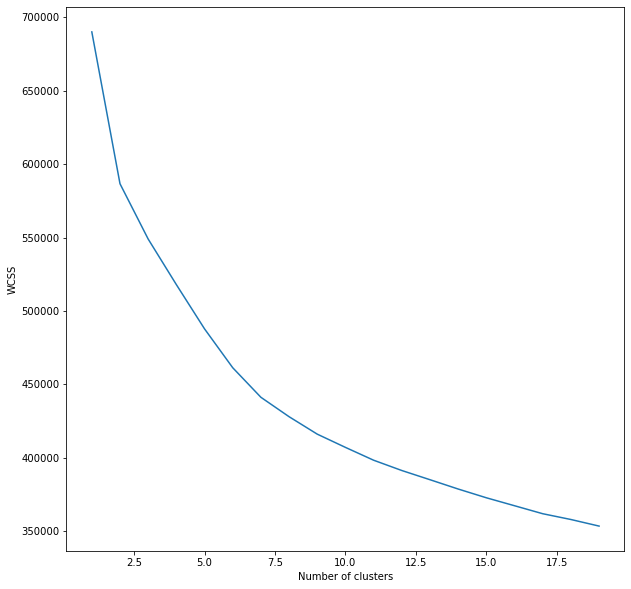

In [23]:
# finding optimal cluster amount
wcss = []
for i in range(1,20):
   model = KMeans(n_clusters = i, init = "k-means++", random_state=67)
   model.fit(cluster_df_scaled)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,20), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
# reducing dimensionality
pca = PCA(2)
data = pca.fit_transform(cluster_df_scaled)
data

array([[-0.09704676, -0.14432955],
       [-0.76629842,  3.02484519],
       [-1.93995507,  1.06308126],
       ...,
       [-2.13104933, -2.27874364],
       [-3.10395854, -1.04380683],
       [ 3.02882386, -0.43075345]])

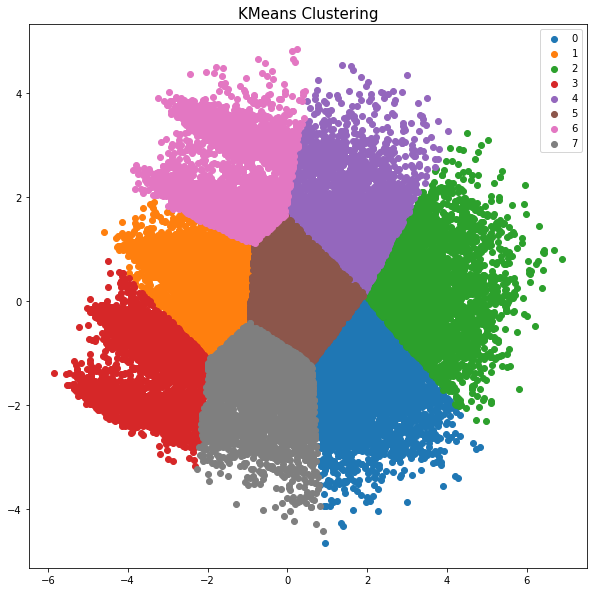

In [25]:
# clustering with PCA components

model = KMeans(n_clusters = 8, init = "k-means++")
label = model.fit_predict(data)


plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('KMeans Clustering', fontsize=15)
plt.show()

In [26]:
metrics.silhouette_score(cluster_df_scaled, label)

0.04945206697650716

### DBSCAN Clustering

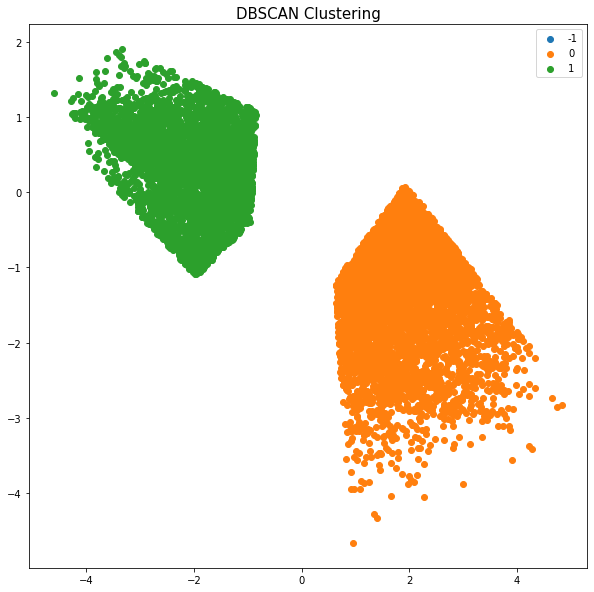

In [35]:
# clustering with PCA components

dbscan = DBSCAN(eps=0.3)
dbscan_label = dbscan.fit_predict(data)

plt.figure(figsize=(10,10))
uniq = np.unique(dbscan_label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('DBSCAN Clustering', fontsize=15)
plt.show()

In [36]:
metrics.silhouette_score(cluster_df_scaled, dbscan_label)

0.15017256646052127

#### Hierarchical Agglomerative Clustering (HAC) Clustering

In [29]:
# utilizing a dendrogram to find the optimal number of clusters

#dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
#plt.title('Dendrogram')
#plt.show()

In [30]:
# hac = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
# hac_label = hac.fit_predict(data)

# plt.figure(figsize=(10,10))
# uniq = np.unique(hac_label)
# for i in uniq:
#    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


# plt.legend()
# plt.title('HAC Clustering', fontsize=15)
# plt.show()

In [31]:
# metrics.silhouette_score(cluster_df_scaled, hac_label)

In [32]:
# result_df = df.copy()
# result_df['kmeans_cluster'] = label
# result_df['dbscan_cluster'] = dbscan_label
# result_df['hac_cluster'] = hac_label
# result_df.info()

### Deployment (10 points total)
- Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
- How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

Doug to Bull shit

### Exceptional Work (10 points total)
You have free reign to provide additional analyses or combine analyses

In [34]:
#Exception work above.